In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget https://data.mendeley.com/datasets/t9ndx37v5h/1

--2021-11-25 13:38:47--  https://data.mendeley.com/datasets/t9ndx37v5h/1
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘1’

1                       [  <=>               ]  67.43K   249KB/s    in 0.3s    

2021-11-25 13:38:48 (249 KB/s) - ‘1’ saved [69050]



In [ ]:
%tensorflow_version 2.x

In [ ]:
import tensorflow
print(tensorflow.__version__)

2.7.0


In [ ]:
!unzip /content/drive/MyDrive/MedicalExpert-I.zip -d data

Archive:  /content/drive/MyDrive/MedicalExpert-I.zip
   creating: data/MedicalExpert-I/
   creating: data/MedicalExpert-I/0Normal/
 extracting: data/MedicalExpert-I/0Normal/NormalG0 (1).png  
 extracting: data/MedicalExpert-I/0Normal/NormalG0 (10).png  
 extracting: data/MedicalExpert-I/0Normal/NormalG0 (100).png  
  inflating: data/MedicalExpert-I/0Normal/NormalG0 (101).png  
 extracting: data/MedicalExpert-I/0Normal/NormalG0 (102).png  
  inflating: data/MedicalExpert-I/0Normal/NormalG0 (103).png  
  inflating: data/MedicalExpert-I/0Normal/NormalG0 (104).png  
  inflating: data/MedicalExpert-I/0Normal/NormalG0 (105).png  
 extracting: data/MedicalExpert-I/0Normal/NormalG0 (106).png  
 extracting: data/MedicalExpert-I/0Normal/NormalG0 (107).png  
 extracting: data/MedicalExpert-I/0Normal/NormalG0 (108).png  
  inflating: data/MedicalExpert-I/0Normal/NormalG0 (109).png  
 extracting: data/MedicalExpert-I/0Normal/NormalG0 (11).png  
  inflating: data/MedicalExpert-I/0Normal/NormalG0 (11

#Data Preprocessing

In [ ]:
import cv2,os
data_path='/content/data/MedicalExpert-I/'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary
print(label_dict)
print(categories)
print(labels)

{'1Doubtful': 0, '2Mild': 1, '4Severe': 2, '3Moderate': 3, '0Normal': 4}
['1Doubtful', '2Mild', '4Severe', '3Moderate', '0Normal']
[0, 1, 2, 3, 4]


In [ ]:
img_size=224
data=[]
label=[]
img = image.load_img(img_path, target_size=(224, 224))
for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the image  into 256 x 256, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            label.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)
        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

# Recale and assign  catagorical labels

In [ ]:
import numpy as np
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
label=np.array(label)
from keras.utils import np_utils
new_label=np_utils.to_categorical(label)

In [ ]:
new_label.shape

(1650, 5)

#CNN Model

In [ ]:
data.shape

(1650, 224, 224, 1)

In [ ]:
data.shape[1:]

(224, 224, 1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(128,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The thrid convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
#Flatten layer to stack the output convolutions from 3rd convolution layer
model.add(Dropout(0.2))

model.add(Dense(128,activation='relu'))
#Dense layer of 128 neurons

model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
#Dense layer of 64 neurons

model.add(Dense(5,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 128)     1280      
                                                                 
 activation (Activation)     (None, 254, 254, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      73792     
                                                                 
 activation_1 (Activation)   (None, 125, 125, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                    

# Splitting data into traning and testing

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data,new_label,test_size=0.1)

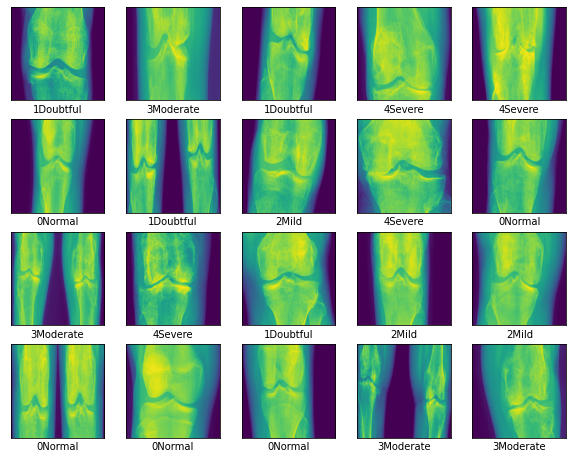

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(x_test[i]))
    plt.xlabel(categories[np.argmax(y_test[i])])
plt.show()

In [ ]:
history=model.fit(x_train,y_train,epochs=100,validation_split=0.2)

Epoch 1/100
38/38 [==============================] - 12s 89ms/step - loss: 1.5309 - accuracy: 0.3308 - val_loss: 1.5613 - val_accuracy: 0.3131
Epoch 2/100
38/38 [==============================] - 3s 74ms/step - loss: 1.5069 - accuracy: 0.3636 - val_loss: 1.4674 - val_accuracy: 0.3401
Epoch 3/100
38/38 [==============================] - 3s 74ms/step - loss: 1.4450 - accuracy: 0.3771 - val_loss: 1.4461 - val_accuracy: 0.3636
Epoch 4/100
38/38 [==============================] - 3s 74ms/step - loss: 1.4166 - accuracy: 0.3906 - val_loss: 1.4311 - val_accuracy: 0.3367
Epoch 5/100
38/38 [==============================] - 3s 74ms/step - loss: 1.3784 - accuracy: 0.4108 - val_loss: 1.4081 - val_accuracy: 0.3434
Epoch 6/100
38/38 [==============================] - 3s 74ms/step - loss: 1.3585 - accuracy: 0.4217 - val_loss: 1.4021 - val_accuracy: 0.3502
Epoch 7/100
38/38 [==============================] - 3s 74ms/step - loss: 1.3270 - accuracy: 0.4226 - val_loss: 1.4168 - val_accuracy: 0.3569
Epoch

In [ ]:
model.save('nomal_model.h5')

In [ ]:
from matplotlib import pyplot as plt

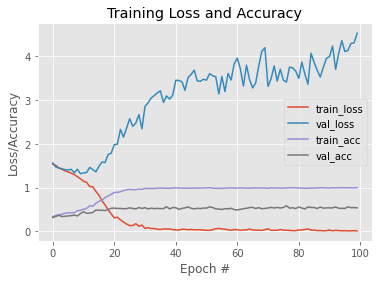

In [ ]:
# plot the training loss and accuracy
N = 100 #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("CNN_Model")

In [ ]:
vaL_loss, val_accuracy= model.evaluate(x_test, y_test, verbose=0)
print("test loss:", vaL_loss,'%')
print("test accuracy:", val_accuracy,"%")

test loss: 5.103246212005615 %
test accuracy: 0.5515151619911194 %


prediction: 1Doubtful
Correct prediction for label 0 is 1Doubtful


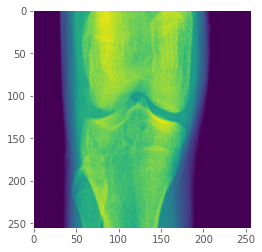

In [ ]:
X = 7

img_size = 256

img_single = x_test[X]
img_single = cv2.resize(img_single, (img_size, img_size))
img_single = (np.expand_dims(img_single, 0))
img_single = img_single.reshape(img_single.shape[0],256,256,1)

predictions_single = model.predict(img_single)
print('prediction:',categories[np.argmax(predictions_single)])
print("Correct prediction for label",np.argmax(y_test[X]),'is',categories[np.argmax(y_test[X])])
plt.imshow(np.squeeze(img_single))
plt.grid(False)
plt.show()

<Figure size 432x288 with 0 Axes>

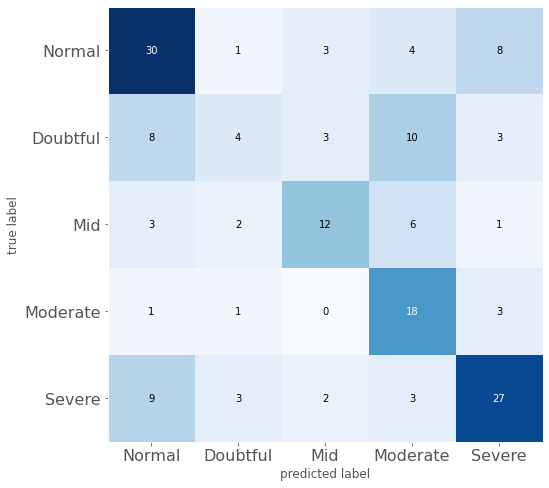

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

test_labels = np.argmax(y_test, axis=1)
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=-1)


cm  = confusion_matrix(test_labels, predictions)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(5), ['Normal','Doubtful','Mid','Moderate','Severe'], fontsize=16)
plt.yticks(range(5), ['Normal','Doubtful','Mid','Moderate','Severe'], fontsize=16)
plt.show()